<a id="index"></a>
# A modular processing pipeline for spike sorting from axona raw data

The notebook largely follows the [spiketutorial notebook from the Sep. 2020 developer workshop](https://github.com/SpikeInterface/spiketutorials/blob/master/NWB_Developer_Breakout_Session_Sep2020/SpikeInterface_Tutorial.ipynb): 

In this notebook we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison for axona raw, axona unit and intan data. We will be using `spikeinterface` from the [SpikeInterface](https://github.com/SpikeInterface) github organization. 

`spikeinterface` wraps 5 subpackages: `spikeextractors`, `spikesorters`, `spiketoolkit`, `spikecomparison`, and `spikewidgets`.

We will show how to
1. [Install dependencies](#install_dependencies)
2. [load data with spikeextractors](#load_data)
3. [Preprocess the signals](#preprocess)
4. [Cache data](#cache)
5. [Spike sorting](#spike_sorting)
6. [Postprocess the signals](#postprocessing)
7. [Curate the spike sorting output](#spike_curation) using 1) quality metrics (automatic), 2) [Phy](https://github.com/cortex-lab/phy) (manual), and 3) consensus-based curation
8. [Export results to NWB](#export_nwb)
9. [Export results to TINT](#export_tint)


<a id='install_dependencies'></a>
# Install dependencies
[back to index](#index)

TODO streamline installation with requirements.txt, ultimately we will only use spikeinterface

We recommend creating a new `spiketutorial` conda environment using:

`conda env create -f environment.yml`

In addition, for the conda environment, you need to install [Phy](https://github.com/cortex-lab/phy) for the manual curation step.

`pip install phy --pre --upgrade`


Alternatively, you can install the requirements you can use the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

(in this case Phy should be automatically installed)

Note that some spike sorters require matlab or additional dependencies, which need to be installed separately. For an overview of possible spike sorters and their dependencies see https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html.

In [1]:
!which python

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python


In [2]:
!ls -l

total 2472
-rwxrwxrwx 1 steburg steburg     198 Apr 13 21:11 Dockerfile
-rwxrwxrwx 1 steburg steburg   54974 Apr  4 15:33 SpikeInterface_Tutorial.ipynb
-rwxrwxrwx 1 steburg steburg     800 Apr 12 20:23 axona_tutorial_re.nwb
-rwxrwxrwx 1 steburg steburg  171124 Apr  5 17:18 axona_tutorial_se.nwb
-rwxrwxrwx 1 steburg steburg     451 Apr 13 21:11 channel_groups.prb
-rwxrwxrwx 1 steburg steburg    2208 Apr 12 20:27 export_from_spikeinterface_to_tint.ipynb
drwxrwxrwx 1 steburg steburg    4096 Apr  1 21:38 ironclust
drwxrwxrwx 1 steburg steburg    4096 Apr 13 09:53 klusta_docker
-rwxrwxrwx 1 steburg steburg  236408 Apr 11 21:26 m2_modular_pipeline_spikesorters_docker.ipynb
-rwxrwxrwx 1 steburg steburg 1659656 Apr 14 10:45 milestone2_modular_pipeline_colab.ipynb
drwxrwxrwx 1 steburg steburg    4096 Apr  4 15:16 phy_KL
drwxrwxrwx 1 steburg steburg    4096 Apr  1 19:29 python-neo
drwxrwxrwx 1 steburg steburg    4096 Apr 10 17:01 spikeextractors
-rwxrwxrwx 1 steburg steburg  149348 Apr 13 21:45 

In [3]:
# Ultimately this is the only command needed, but for now we need
# to install from github to obtain work in progress.

#!pip install spikeinterface

Once axonarecordingextractors are integrated into spikeextractors, 
installing spikeinterface should be sufficient. For now we also need to
clone spikeextractors and python-neo with the necessary components
(e.g. branch axonarawio for python-neo).

In [4]:
!git clone https://github.com/catalystneuro/python-neo.git

fatal: destination path 'python-neo' already exists and is not an empty directory.


In [5]:
!ls -l

total 2472
-rwxrwxrwx 1 steburg steburg     198 Apr 13 21:11 Dockerfile
-rwxrwxrwx 1 steburg steburg   54974 Apr  4 15:33 SpikeInterface_Tutorial.ipynb
-rwxrwxrwx 1 steburg steburg     800 Apr 12 20:23 axona_tutorial_re.nwb
-rwxrwxrwx 1 steburg steburg  171124 Apr  5 17:18 axona_tutorial_se.nwb
-rwxrwxrwx 1 steburg steburg     451 Apr 13 21:11 channel_groups.prb
-rwxrwxrwx 1 steburg steburg    2208 Apr 12 20:27 export_from_spikeinterface_to_tint.ipynb
drwxrwxrwx 1 steburg steburg    4096 Apr  1 21:38 ironclust
drwxrwxrwx 1 steburg steburg    4096 Apr 13 09:53 klusta_docker
-rwxrwxrwx 1 steburg steburg  236408 Apr 11 21:26 m2_modular_pipeline_spikesorters_docker.ipynb
-rwxrwxrwx 1 steburg steburg 1659656 Apr 14 10:45 milestone2_modular_pipeline_colab.ipynb
drwxrwxrwx 1 steburg steburg    4096 Apr  4 15:16 phy_KL
drwxrwxrwx 1 steburg steburg    4096 Apr  1 19:29 python-neo
drwxrwxrwx 1 steburg steburg    4096 Apr 10 17:01 spikeextractors
-rwxrwxrwx 1 steburg steburg  149348 Apr 13 21:45 

In [6]:
%cd ./python-neo
!python3 setup.py develop
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
running develop
running egg_info
writing neo.egg-info/PKG-INFO
writing dependency_links to neo.egg-info/dependency_links.txt
writing requirements to neo.egg-info/requires.txt
writing top-level names to neo.egg-info/top_level.txt
reading manifest file 'neo.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'drafts'
no previously-included directories found matching 'doc/build'
writing manifest file 'neo.egg-info/SOURCES.txt'
running build_ext
Creating /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/neo.egg-link (link to .)
Adding neo 0.9.0 to easy-install.pth file

Installed /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
Processing dependencies for neo==0.9.0
Searching for quantities>=0.12.1
Reading https://pypi.org/simple/quantities/
Best match: quantities 0.12.4
Processing quantities-0.12.4.tar.gz
Writing /tmp/easy_install-

In [68]:
!git clone https://github.com/catalystneuro/spikeextractors.git

fatal: destination path 'spikeextractors' already exists and is not an empty directory.


In [7]:
%cd ./spikeextractors
!python3 setup.py develop
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
running develop
running egg_info
writing spikeextractors.egg-info/PKG-INFO
writing dependency_links to spikeextractors.egg-info/dependency_links.txt
writing requirements to spikeextractors.egg-info/requires.txt
writing top-level names to spikeextractors.egg-info/top_level.txt
reading manifest file 'spikeextractors.egg-info/SOURCES.txt'
writing manifest file 'spikeextractors.egg-info/SOURCES.txt'
running build_ext
Creating /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/spikeextractors.egg-link (link to .)
Adding spikeextractors 0.9.5 to easy-install.pth file

Installed /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
Processing dependencies for spikeextractors==0.9.5
Searching for tqdm
Reading https://pypi.org/simple/tqdm/
Best match: tqdm 4.59.0
Processing tqdm-4.59.0-py2.py3-none-any.whl
Installing tqdm-4.59.0-py2.py3-none-any.whl to /mnt/d/spikeinterface/hussaini-to-nwb/ti

Switch to correct branches

In [8]:
%cd python-neo
!git checkout axonarawio
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
Already on 'axonarawio'
Your branch is up to date with 'origin/axonarawio'.
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv


In [9]:
%cd spikeextractors
!git checkout axonaextractor
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
Already on 'axonaextractor'
Your branch is up to date with 'origin/axonaextractor'.
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv


Install other spikeinterface modules using pip (this may take a few minutes). 

In [10]:
!pip install spiketoolkit spikesorters spikecomparison spikewidgets

     |████████████████████████████████| 67 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 1.3 MB/s eta 0:00:01
  Using cached spikecomparison-0.3.2-py3-none-any.whl (28 kB)
  Using cached networkx-2.5-py3-none-any.whl (1.6 MB)
  Using cached pandas-1.2.3-cp38-cp38-manylinux1_x86_64.whl (9.7 MB)
  Using cached scikit_learn-0.24.1-cp38-cp38-manylinux2010_x86_64.whl (24.9 MB)
     |████████████████████████████████| 27.2 MB 1.5 MB/s eta 0:00:01     |███████████████████████████████ | 26.4 MB 9.2 MB/s eta 0:00:01
  Using cached spikefeatures-0.1.2.tar.gz (4.5 kB)
  Using cached spikemetrics-0.2.4.tar.gz (18 kB)
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached MEAutility-1.4.8.tar.gz (33 kB)
     |████████████████████████████████| 10.3 MB 4.2 MB/s eta 0:00:01    |██████▍                         | 2.1 MB 5.8 MB/s eta 0:00:02     |██████████████████████████████▎ | 9.7 MB 4.2 MB/s eta 0:00:01
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB

  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-zvap1k0e/MEAutility/setup.py'"'"'; __file__='"'"'/tmp/pip-install-zvap1k0e/MEAutility/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-7v4e8p3m
       cwd: /tmp/pip-install-zvap1k0e/MEAutility/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for MEAutility
  Running setup.py clean for MEAutility
Failed to build spiketoolkit spikesorters spikewidgets spikefeatures sp

Finally, we should downgrade h5py to version 2.10.0 to be as compatible as possible with spikesorters

In [3]:
!pip install h5py==2.10.0

  Using cached h5py-2.10.0-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)


__Note__: You need to restart the kernel before you can import the newly installed packages.

Import packages

In [1]:
# General data handling and visualization
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size':20})

# SpikeInterface
import spikeextractors as se
import spikewidgets as sw
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc

print(sys.version, sys.platform, sys.executable)

13:20:04 [I] klustakwik KlustaKwik2 version git-bd471251-dirty


3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0] linux /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3


We can see all existing recordingextractors, as well as the ones installed and available to us with the following commands.

In [2]:
se.recording_extractor_full_list

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.mearecextractors.mearecextractors.MEArecRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.exdirextractors.exdirextractors.ExdirRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysNPIXRecordingExtractor,
 spikeextractors.extractors.intanrecordingextractor.intanrecordingextractor.IntanRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spyking

In [3]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxwellextractors.maxwellextractors.MaxOneRecordingExtractor,
 spikeextractors.extractors.maxwellextractors.maxwellextractors.MaxTwoRecordingExtractor,
 spikeextractors.extractors.mcsh5recordingextractor.m

<a id='load_data'></a>
# 2. Load data
[back to index](#index)

Set path and base filename and create an `AxonaRecordingExtractor` instance. The `AxonaRecordingExtractor` will process .bin data together with a .set file. It is sufficient to pass the base filename (without ending), assuming that both files are in the same directory (.bin or .set extensions will also work). 

In [4]:
dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = 'axona_raw_5s'
filename = os.path.join(dir_name, base_filename)
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/axona_raw_5s


In [5]:
recording = se.AxonaRecordingExtractor(filename=filename)

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). 

Here we load information from the recording using the built-in functions from the RecordingExtractor.

In [6]:
print('Type of recorindextractor:', type(recording))
print('Channel ids: {}'.format(recording.get_channel_ids()))
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. samples = {}'.format(recording.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(recording.get_traces(
    start_frame=0, end_frame=48000, channel_ids=2))))
print('Location of third electrode = {}'.format(recording.get_channel_property(channel_id=2, property_name='location')))

Type of recorindextractor: <class 'spikeextractors.extractors.neoextractors.axonaextractor.AxonaRecordingExtractor'>
Channel ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Num. channels = 16
Sampling frequency = 48000.0 Hz
Num. samples = 720000


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

Stdev. on third channel = 6921.685546875
Location of third electrode = [nan nan]


The `spikewidgets` module includes several convenient plotting functions that can be used to explore the data:

Visualize channels in time domain (from 2.0 to 2.1 seconds).

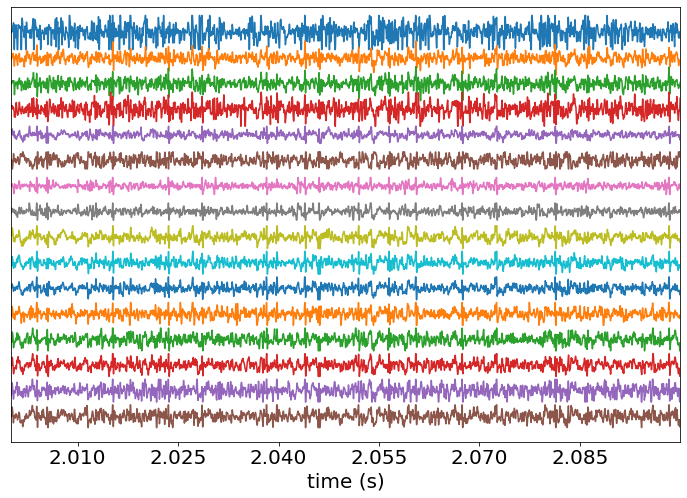

In [7]:
w_ts = sw.plot_timeseries(recording, trange=[2, 2.1])

Visualize data from a subset of 8 channels in the frequency domain.

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

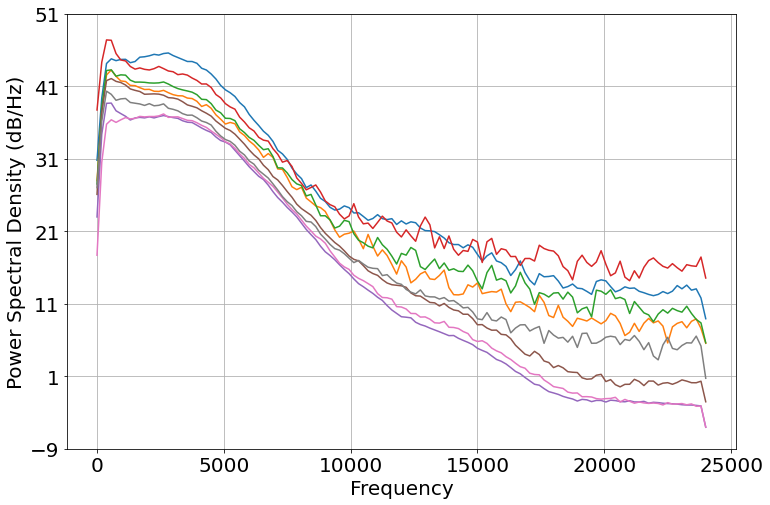

In [8]:
w_sp = sw.plot_spectrum(recording, trange=[0, 5], channels=[1, 2, 3, 4, 5, 6, 7, 8])

It often makes sense to group electrodes together, for instance if they belong to the same tetrode. We can do so by assigning the `groups` property for each channel. This can be done with the `set_channel_groups` method. Correspondingly, we can view this property using the `get_channel_groups` method. Initially all channels are assigned to group zero.  

An alternative way to obtain channel groups is by loading a so called `.prb` file containing channel grouping and physical channel locations. 

In [9]:
print(f'Channel groups at initialization:\n{recording.get_channel_groups()}')

Channel groups at initialization:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
recording.set_channel_groups([i//4 for i in range(len(recording.get_channel_ids()))])

print(f'Updated channel groups with a 4 channel per tetrode scheme:\n{recording.get_channel_groups()}')

Updated channel groups with a 4 channel per tetrode scheme:
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


Some spike sorters (e.g. ironclust) require channel locations. So we will create a fake geometry keeping electrodes on single tetrodes close together. A common way to do this is with a .prb file containing a json dictionary like the one below. If the actual geometry is known, you can of course use that instead. 

In [141]:
# We simply paste this code into a .prb file
prb_file_content = '''
channel_groups = {
    0: {
        'channels': [1, 2, 3, 4],
        'geometry': [[0, 0], [1, 0], [2, 0], [3, 0]],
    },
    1: {
        'channels': [5, 6, 7, 8],
        'geometry': [[6, 0], [7, 0], [8, 0], [9, 0]],
    },
    2: {
        'channels': [9, 10, 11, 12],
        'geometry': [[12, 0], [13, 0], [14, 0], [15, 0]],
    },
    3: {
        'channels': [13, 14, 15, 16],
        'geometry': [[18, 0], [19, 0], [20, 0], [21, 0]],
    }
}
'''
f = open(os.path.join(dir_name, "channel_groups.prb"), "w")
f.write(prb_file_content)
f.close()

We now have the additional channel property `location`.

In [142]:
recording_prb = recording.load_probe_file(os.path.join(dir_name, 'channel_groups.prb'))
print('Channel ids:', recording_prb.get_channel_ids())
print('Loaded properties', recording_prb.get_shared_channel_property_names())

# 'group' and 'location' can be returned as lists:
print('Channel groups:', recording_prb.get_channel_groups())
print('Channel locations:\n', recording_prb.get_channel_locations())

Channel ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Loaded properties ['gain', 'group', 'location', 'name', 'offset']
Channel groups: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Channel locations:
 [[ 0.  0.]
 [ 1.  0.]
 [ 2.  0.]
 [ 3.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  0.]
 [ 9.  0.]
 [12.  0.]
 [13.  0.]
 [14.  0.]
 [15.  0.]
 [18.  0.]
 [19.  0.]
 [20.  0.]
 [21.  0.]]


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

We can visualize the electrode locations with spikewidgets:

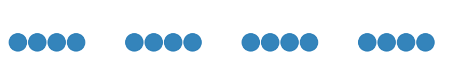

In [143]:
fh = plt.figure(figsize=(8,1))
w_elec = sw.plot_electrode_geometry(recording_prb, figure=fh)

### Properties (and features)

For now we have seen that the `RecordingEctractor` can have `group` and `location` *properies*. These are very special properties that can be very important for spike sorting. Anything related to a channel can be saved as a property.

Similarly, for `SortingExtractor` objects, anything related to a unit can be stored as a property. In addition, for `SortingExtractor` objects we can also store anything related to spikes as *features* (e.g. waveforms, as we'll see later).

We can check which properties are in the extractor as follows:

In [20]:
print('Shared channel property names')
print(recording_prb.get_shared_channel_property_names())

Shared channel property names
['gain', 'group', 'location', 'name', 'offset']


<a id='preprocess'></a>
# 3. Preprocessing
[back to index](#index)

Now that the probe information is loaded we can do some preprocessing using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings, remove a noisy channel, and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

TODO this is not entirely arrucate:

Below, we bandpass filter the recording between 300 and 6000 Hz, remove channels 1-4, and apply a common median reference scheme.

### Bandpass filter

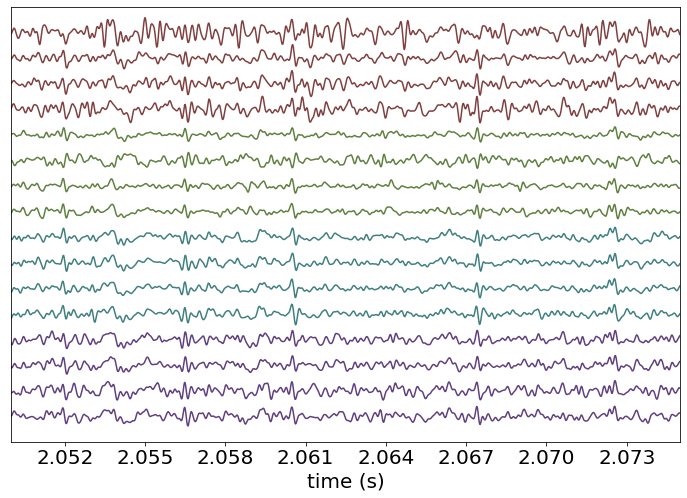

In [144]:
r_filt = st.preprocessing.bandpass_filter(recording_prb, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(r_filt, trange=[2.05, 2.075], color_groups=True)

### Remove bad channels

Interestingly, there are a lot of spikes that appear in all channels. This is unexpected, because channels are too far apart to register firing of the same neuron. Only spike events within a tetrode are expected. Oddly, channel 6 shows an inverted pattern for these unexpected spikes. To illustrate how to exclude channels we will remove it. We can do so as follows (alternatively we could create a `SubRecordingExtractor` and specify the channel IDs to keep):

In [176]:
r_good_channels = st.preprocessing.remove_bad_channels(r_filt, bad_channel_ids=[1,2,3,4])
print(f'Channel ids after removing bad channel: {r_good_channels.get_channel_ids()}')
print(f'Channel groups after removing bad channel: {r_good_channels.get_channel_groups()}')

Channel ids after removing bad channel: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Channel groups after removing bad channel: [1 1 1 1 2 2 2 2 3 3 3 3]


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

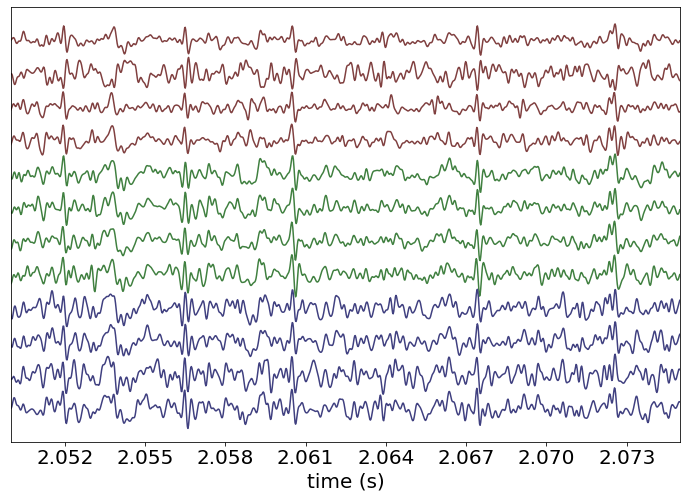

In [177]:
w = sw.plot_timeseries(r_good_channels, trange=[2.05, 2.075], color_groups=True)

### Common median reference (CMR)

It is often desirable to use a common median reference to remove noise common to all channels. In our case this will remove the apparent spike events spanning the whole channel set. 

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

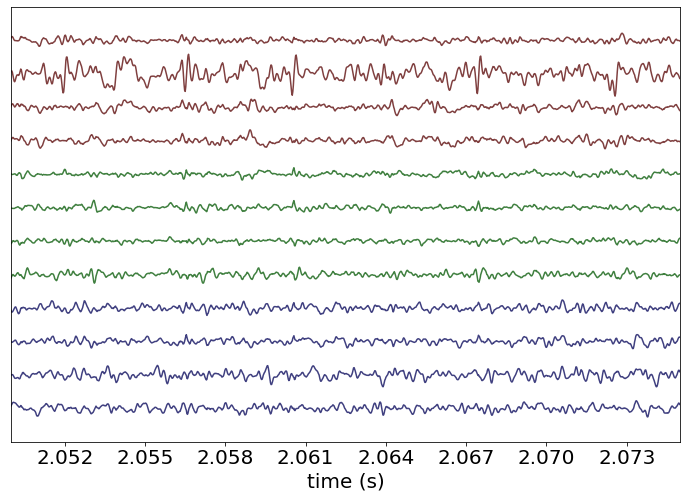

In [178]:
r_cmr = st.preprocessing.common_reference(r_good_channels, reference='median')
w = sw.plot_timeseries(r_cmr, trange=[2.05, 2.075], color_groups=True)

We can also select subsets of data in the time domain with `SubRecordingExtractor`. For illustrative purposes and to speed up computation time of the spike sorters, we will select a 2 s sub-window. 


In [179]:
fs = r_cmr.get_sampling_frequency()
r_sub = se.SubRecordingExtractor(r_cmr, start_frame=1*fs, end_frame=3*fs)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

<a id='cache'></a>
# 4. Cache data
[back to index](#index)

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **cache** it to a file and perform those operations (eg. filters, CMR, etc.) at once. This is particularly important if we are going to extract waveforms, templates, pca scores, or in general *post-process* the results.

Note that if the parameter `save_path` is not specified, the cache file will be saved in a temporary folder that will be deleted when the Python session is closed (or the object destroyed). One can get around this by moving the temporary file with `recording_cache.move_to()`, or simply specifying the `save_path` paramter when creating the cache. You can view the directory of the temporary folder with `recording_cache.get_tmp_folder()`.

In [180]:
perma_cache_filename = os.path.join(dir_name, 'cached_data_preproc.dat') 
r_cache = se.CacheRecordingExtractor(r_sub, save_path = perma_cache_filename)
print('Temporary folder:\n{}'.format(r_cache.get_tmp_folder()))

Temporary folder:
/tmp/tmpkuop30nu


Under the hood, this convenient function is retrieving all the traces (in chunks, to save up some memory), applying the preprocessing steps, and dumping them to a binary temporary file:

In [181]:
print(f'Filename: {r_cache.filename}')

Filename: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/cached_data_preproc.dat


The cached recording has all the previously loaded information:

In [182]:
print(f'Cached channels: {r_cache.get_channel_ids()}')
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Cached channels ids: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Channel groups after caching: [1 1 1 1 2 2 2 2 3 3 3 3]
Duration of recording in seconds: 2.0


If we now closed the Python session, we would have a nice `.dat` file, but no information on how to open it! 
In order to save the state of an extractor, we can use the **dumping** mechanism.
Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:

In [183]:
r_cache.dump_to_dict()

{'class': 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'file_path': '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/cached_data_preproc.dat',
  'sampling_frequency': 48000.0,
  'numchan': 12,
  'dtype': 'float32',
  'recording_channels': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
  'time_axis': 0,
  'geom': None,
  'file_offset': 0,
  'gain': None,
  'is_filtered': True},
 'key_properties': {'group': array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
  'location': array([[ 6.,  0., nan],
         [ 7.,  0., nan],
         [ 8.,  0., nan],
         [ 9.,  0., nan],
         [12.,  0., nan],
         [13.,  0., nan],
         [14.,  0., nan],
         [15.,  0., nan],
         [18.,  0., nan],
         [19.,  0., nan],
         [20.,  0., nan],
         [21.,  0., nan]]),
  'gain': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'offset': array([0., 0., 

We can now dump our extractor object, so it can be loaded in a future session. We can dump either to `.json` or to `.pkl`. Dumping to pickle also allow us to store properties (other than group and locations) and features (for `SortingExtractor` objects).

In [184]:
r_cache.dump_to_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In another session, we can pick up from where we left by loading the extractor from the pickle file:

In [185]:
r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In [186]:
print(f'Cached channels: {r_cache.get_channel_ids()}')
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Cached channels ids: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Channel groups after caching: [1 1 1 1 2 2 2 2 3 3 3 3]
Duration of recording in seconds: 2.0


**IMPORTANT**: the same caching/dumping mechanisms are available also for all `SortingExtractor` objects.

<a id='spike_sorting'></a>
# 5. Spike sorting
[back to index](#index)

We will now run spike sorting on the above recording (`r_cache`). We will use `klusta`, `ironclust` and `mountainsort4` for this demonstration, to show how easy SpikeInterface makes it to interchengably run different sorters.

First, we need to install the spike sorters we want. There is a complete overview of spike sorters supported by spikeinterface here: https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html, including installation instructions. Note that not all spikesorters work on every setup. Some require Matlab. Some require CUDA. 

In [127]:
# TODO: delete: In this notebook we will focus on `ironclust`, `kilosort`, `spyking circus` and `mountainsort`. 

Show installed spike sorting algorithms.

In [128]:
ss.installed_sorters()

['herdingspikes', 'ironclust', 'klusta', 'mountainsort4', 'spykingcircus']

### Klusta

Install `Klusta` with pip.

In [52]:
!pip install Cython h5py tqdm
!pip install click klusta klustakwik2

  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Using cached klusta-3.0.16-py2.py3-none-any.whl (87 kB)
  Using cached klustakwik2-0.2.6.zip (712 kB)
  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-1alxlhvm/klustakwik2/setup.py'"'"'; __file__='"'"'/tmp/pip-install-1alxlhvm/klustakwik2/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-hlwig7as
       cwd: /tmp/pip-install-1alxlhvm/klustakwik2/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  -----------------------------------

We can retrieve the parameters associated with any sorter with the `get_default_params()` function from the `spikesorters` module, as well as corresponding parameter descriptions using `get_params_description()`.

In [48]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [49]:
ss.get_params_description('klusta')

{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'num_starting_clusters': 'Number of initial clusters',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [50]:
ss.run_sorter?

In [51]:
ss.run_klusta?

Since we have tetrodes and we know that they are physically apart, we would like to sort them separately as follows, assigning the `group` property to the `grouping_property` parameter:

In [193]:
sorting_KL = ss.run_klusta(
    r_cache,
    adjacency_radius=50,
    output_folder=os.path.join(dir_name, 'klusta_by_group'),
    grouping_property='group',
    parallel=True,
    threshold_weak_std_factor=2
)
print(f'Klusta found {len(sorting_KL.get_unit_ids())} units')

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

Klusta found 10 units


Below you can see that when the `grouping_property` is used a `MultiSortingExtractor` object is returned, containing several `SortingExtractor` objects, which were created separately for each group. 

In [194]:
print(type(sorting_KL))
print(type(sorting_KL.sortings[0]))

<class 'spikeextractors.multisortingextractor.MultiSortingExtractor'>
<class 'spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor'>


In [195]:
print(f'Klusta unit ids (with groups): {sorting_KL.get_unit_ids()}')

Klusta unit ids (with groups): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [196]:
print(f'Spike train of a unit: {sorting_KL.get_unit_spike_train(1)}')

Spike train of a unit: [  263   667  1277 ... 95706 95773 95876]


We can also look at raster plots:

In [197]:
sw.plot_rasters?

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

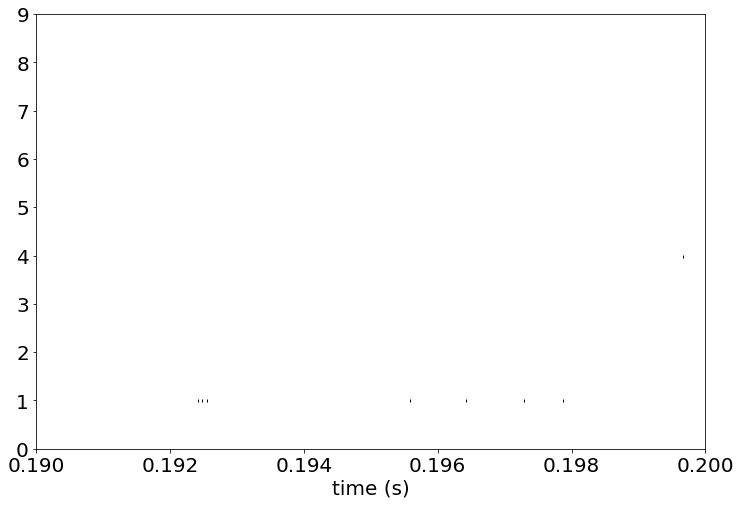

In [200]:
w_rs = sw.plot_rasters(sorting_KL, trange=[0.19,0.2])

Do we see this reflected in the recording traces?

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

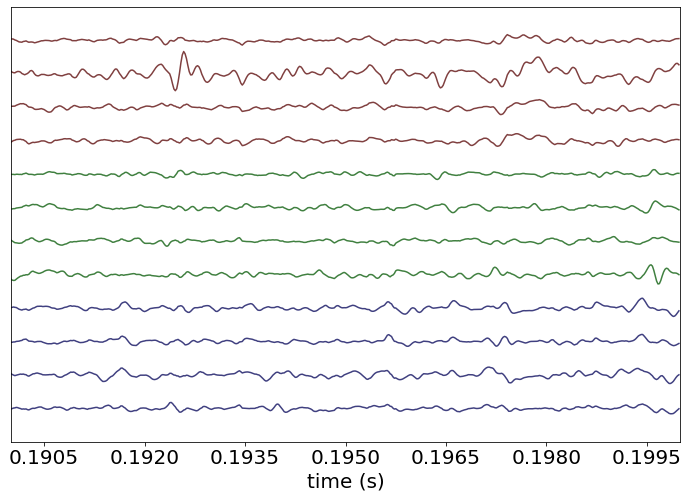

In [201]:
w = sw.plot_timeseries(r_cache, trange=[0.19, 0.2], color_groups=True)

Hardly... What about Ironclust (you need to scroll down and run sorting_IC = ... first!)

In [168]:
sorting_IC.get_sampling_frequency()

48000.0

In [171]:
RasterWidget??

Object `sw._RasterWidget` not found.


In [167]:
sw.plot_rasters??

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

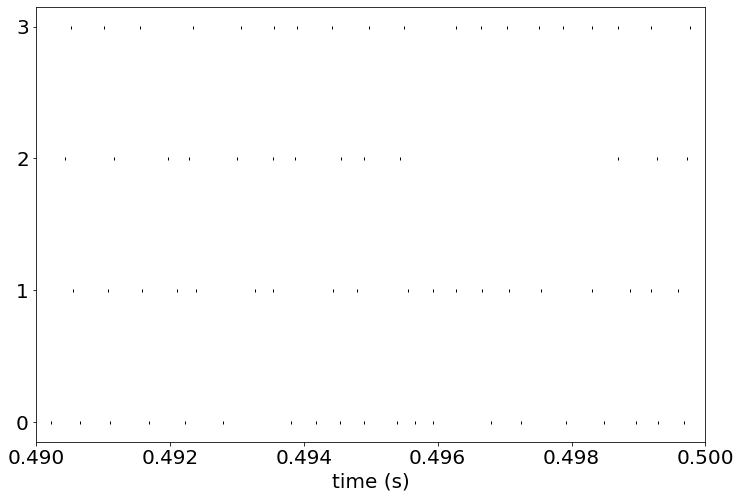

In [165]:
w_rs = sw.plot_rasters(sorting_IC, trange=[0.49,0.5])


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

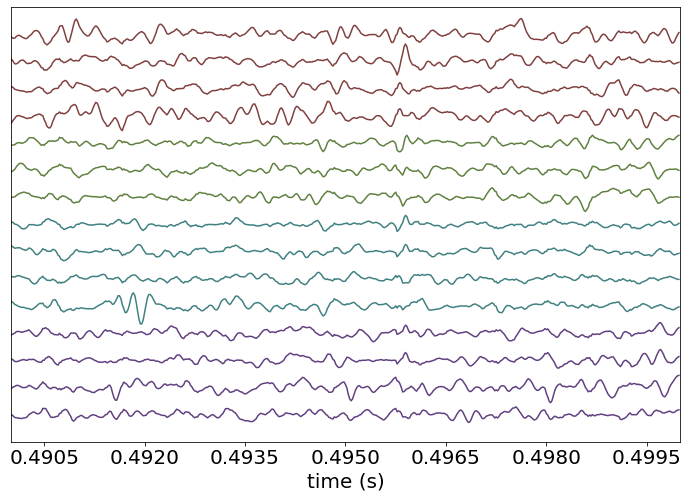

In [166]:
w = sw.plot_timeseries(r_cmr, trange=[0.49, 0.5], color_groups=True)

Can I check if this works fine when not using an `AxonaRecordingExtractor`?

### Loading spike sorting output from a spike sorting folder

If a spike sorter has been run, you can reload the output as a `SortingExtractor` using the corresponding `spikeextractors` class. Note that if sorting by group/property, single groups must be loaded separately:

In [162]:
# Reloading spike sorting output (note that if sorting by group or property they need to be loaded in separately)

sorting_KL_grp = {}
for i in range(0, 3):
    sorting_KL_grp[i] = se.KlustaSortingExtractor(os.path.join(dir_name, 'klusta_by_group', str(i)))

In [163]:
sorting_KL_grp

{0: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7f1a851ec250>,
 1: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7f1a851c18b0>,
 2: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7f1a851d8a30>}

In [164]:
print(f'Klusta unit ids group 0: {sorting_KL_grp[0].get_unit_ids()}')

Klusta unit ids group 0: [2, 3, 4, 5]


### Ironclust

If you haven't already, clone Ironclust github repository to a path or your choice. Here we stay in the same directory. 

In [29]:
!git clone https://github.com/jamesjun/ironclust

Cloning into 'ironclust'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 4964 (delta 131), reused 119 (delta 62), pack-reused 4775
Receiving objects: 100% (4964/4964), 83.82 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (3556/3556), done.
Updating files: 100% (846/846), done.


In [18]:
ss.get_default_params('ironclust')

{'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.985,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'bandpass',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'n_jobs_bin': 1,
 'chunk_mb': 500,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': False,
 'filter': True,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95}

In [63]:
ss.get_params_description('ironclust')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'detect_threshold': 'detection threshold',
 'prm_template_name': '.prm template file name',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'merge_thresh': 'Threshold for automated merging',
 'pc_per_chan': 'Number of principal components per channel',
 'whiten': 'Whether to do channel whitening as part of preprocessing',
 'filter_type': 'Filter type: none, bandpass, wiener, fftdiff, ndiff',
 'filter_detect_type': 'Filter type for detection: none, bandpass, wiener, fftdiff, ndiff',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'step_sec_drift': 'Compute anatomic

Next, we set the ironclust path.

In [64]:
ss.IronClustSorter.set_ironclust_path('./ironclust')
ss.IronClustSorter.ironclust_path

Setting IRONCLUST_PATH environment variable for subprocess calls to: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/ironclust


'/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/ironclust'

Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [65]:
ss.installed_sorters()

['herdingspikes', 'ironclust', 'klusta', 'mountainsort4', 'spykingcircus']

In [140]:
sorting_IC = ss.run_ironclust(
    r_cache, 
    os.path.join(dir_name, 'ironclust_group'), 
    grouping_property='group', 
    parallel=True, 
    verbose=True,
    filter=False,  # we already filtered
    detect_threshold=3,  # keep similar to other sorters.
    common_ref_type=None  # we already applied median reference
)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

RuntimeError: Channel locations are required for this spike sorter. Locations can be added to the RecordingExtractor by loading a probe file (.prb or .csv) or by setting them manually.

### Mountainsort4

To install Mountainsort4 we simply use pip. It installs quite a large number of packages, so this might take a few minutes. 

In [33]:
!pip install ml_ms4alg

  Using cached ml_ms4alg-0.3.6-py3-none-any.whl (16 kB)
  Using cached isosplit5-0.1.3.tar.gz (17 kB)
  Using cached pybind11-2.6.2-py2.py3-none-any.whl (191 kB)
     |████████████████████████████████| 935 kB 3.0 MB/s eta 0:00:01
  Using cached h5py-3.2.1-cp38-cp38-manylinux1_x86_64.whl (4.5 MB)
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached mountainlab_pytools-0.7.5-py3-none-any.whl (28 kB)
  Using cached fsspec-0.8.7-py3-none-any.whl (103 kB)
  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
  Using cached toolz-0.11.1-py3-none-any.whl (55 kB)
  Using cached partd-1.1.0-py3-none-any.whl (19 kB)
  Using cached jp_proxy_widget-1.0.10-py2.py3-none-any.whl (1.2 MB)
  Using cached vdom-0.6-py3-none-any.whl (13 kB)
  Using cached numpydoc-1.1.0-py3-none-any.whl (47 kB)
  Using cached locket-0.2.1-py2.py3-none-any.whl (4.1 kB)
  Using cached jupyter_ui_poll-0.1.2-py2.py3-none-any.whl (6.6 kB)
  Using cached Sphinx-3.5.3-py3-none-any.whl (2.8 MB)
  Using cached sphinxcontr

  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-3awm75ww/isosplit5/setup.py'"'"'; __file__='"'"'/tmp/pip-install-3awm75ww/isosplit5/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-arz0jqbb
       cwd: /tmp/pip-install-3awm75ww/isosplit5/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for isosplit5
  Running setup.py clean for isosplit5
  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeint

In [69]:
ss.installed_sorters()

['herdingspikes', 'ironclust', 'klusta', 'mountainsort4', 'spykingcircus']

In [70]:
ss.get_default_params('mountainsort4')

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': True,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [71]:
ss.get_params_description('mountainsort4')

{'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood (Use -1 to include all channels in every neighborhood)',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'filter': 'Enable or disable filter',
 'whiten': 'Enable or disable whitening',
 'curation': 'Enable or disable curation',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'clip_size': 'Number of samples per waveform',
 'detect_threshold': 'Threshold for spike detection',
 'detect_interval': 'Minimum number of timepoints between events detected on the same channel',
 'noise_overlap_threshold': 'Noise overlap threshold for automatic curation'}

In [72]:
sorting_MS4 = ss.run_mountainsort4(
    r_cache,
    os.path.join(dir_name, 'mountainsort4_group'),
    grouping_property='group',
    parallel=False,  # on my local machine mountainsort fails when parallel=True, that is not generally the case
    verbose=True,
    filter=False
)
print(f'Mountainsort4 found {len(sorting_MS4.get_unit_ids())} units')

Using 2 workers.
Using tmpdir: /tmp/tmp9xz8kmmw
Num. workers = 2
Preparing /tmp/tmp9xz8kmmw/timeseries.hdf5...
'end_frame' set to 96000
Preparing neighborhood sorters (M=4, N=96000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp9xz8kmmw
Using 2 workers.
Using tmpdir: /tmp/tmp8m0xp97w
Num. workers = 2
Preparing /tmp/tmp8m0xp97w/timeseries.hdf5...
'end_frame' set to 96000
Preparing neighborhood sorters (M=3, N=96000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp8m0xp97w
Using 2 workers.
Using tmpdir: /tmp/tmp4s8qk0s4
Num. workers = 2
Preparing /tmp/tmp4s8qk0s4/timeseries.hdf5...
'end_frame' set to 96000
Preparing neighborhood sorters (M=4, N=96000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp4s8qk0s4
Using 2 workers.
Using tmpdir: /tmp/tmp7n6r7ffr
Num. workers = 2
Preparing /tmp/tmp7n6r7ffr/timeseries.hdf5...
'end_frame' set to 96000
Preparing neighborhood sorters (M=4, N=96000)...
Preparing output...
Done with ms

In [75]:
print(f'Spike train of a unit: {sorting_MS4.get_unit_spike_train(1)}')

Spike train of a unit: [ 4194  7632  7671  7755  9237 15659 20175 23289 23329 23400 23489 23509
 23549 23572 23599 23637 23671 23736 23753 23804 23824 23862 23923 23941
 23983 23994 24060 24098 24150 25194 25274 25334 25434 25558 25616 25847
 25900 25960 26078 26114 26177 26226 26256 26288 26329 26345 26368 26397
 26425 26443 26467 26517 26529 26559 27895 28579 29594 30592 30716 31791
 31885 31997 32125 32237 33204 33750 33793 33834 33934 33973 35622 35645
 35677 36012 36033 36068 36305 36318 36521 36817 36984 37064 37153 37608
 38680 38753 38841 38919 39143 39200 39233 39290 39329 39417 39508 39598
 39669 39794 39828 39865 39928 40003 40113 41167 49466 49850 50604 51185
 51291 53888 54252 55449 56427 57437 58551 60545 62357 62482 63026 63352
 64794 66728 68424 69261 69767 75247 81660 92330 92632 94118 94899]


### 1. Kilosort
Kilosort, Kilosort2 and Kilosort2.5 all require CUDA, so let's install this first.

In [58]:
# TODO install CUDA

We can install Kilosort by simply cloning the git repository and pointing spikeinterface to the download path.

In [59]:
!git clone https://github.com/cortex-lab/KiloSort

Cloning into 'KiloSort'...
remote: Enumerating objects: 1207, done.
remote: Total 1207 (delta 0), reused 0 (delta 0), pack-reused 1207
Receiving objects: 100% (1207/1207), 2.30 MiB | 5.22 MiB/s, done.
Resolving deltas: 100% (763/763), done.


In [60]:
!ls -l

total 116308
-rw-r--r--  1 root root 103680000 Apr  1 19:26 axona_raw_5s.bin
-rw-r--r--  1 root root     26002 Apr  1 21:38 axona_raw_5s.set
-rw-r--r--  1 root root  15360000 Apr  1 22:07 cached_data_preproc.dat
-rw-r--r--  1 root root      3538 Apr  1 22:07 cached_data_preproc.pkl
-rw-r--r--  1 root root       451 Apr  1 21:53 channel_groups.prb
drwxr-xr-x 15 root root      4096 Apr  1 22:12 KiloSort
drwxr-xr-x  8 root root      4096 Apr  1 19:51 python-neo
drwxr-xr-x  1 root root      4096 Mar 25 13:38 sample_data
drwxr-xr-x  7 root root      4096 Apr  1 19:59 spikeextractors


In [61]:
ss.KilosortSorter.set_kilosort_path('./KiloSort')
ss.KilosortSorter.kilosort_path

Setting KILOSORT_PATH environment variable for subprocess calls to: /content/KiloSort


'/content/KiloSort'

We can inspect a given spike sorters parameters and see a description of their purpose using the following convenience methods.

In [62]:
ss.get_default_params('kilosort')

{'NT': None,
 'Nfilt': None,
 'car': True,
 'chunk_mb': 500,
 'detect_threshold': 6,
 'freq_max': 6000,
 'freq_min': 300,
 'n_jobs_bin': 1,
 'ntbuff': 64,
 'useGPU': True}

In [63]:
ss.get_params_description('kilosort')

{'NT': 'Batch size (if None it is automatically computed)',
 'Nfilt': 'Number of clusters to use (if None it is automatically computed)',
 'car': 'Enable or disable common reference',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'detect_threshold': 'Threshold for spike detection',
 'freq_max': 'Low-pass filter cutoff frequency',
 'freq_min': 'High-pass filter cutoff frequency',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)',
 'ntbuff': 'Samples of symmetrical buffer for whitening and spike detection',
 'useGPU': 'Enable or disable GPU usage'}

Now we call the spike sorter. 

In [70]:
!less kilosort_group/0/kilosort.log

/content/kilosort_group/0/run_kilosort.sh: line 3: matlab: command not found
>8

In [64]:
sorting_KS = ss.run_kilosort(
    r_cache,
    os.path.join(dir_name, 'kilosort_group'),
    grouping_property='group',
    parallel=True,
    verbose=True
)
print(f'Kilosort found {len(sorting_KS.get_unit_ids())} units')

Writing to binary .dat file: 100%|##########| 1/1 [00:00<00:00, 158.07it/s]


SpikeSortingError: ignored

### Kilosort2

In [ ]:
# Add repository path to spikesorters object

ss.Kilosort2Sorter.set_kilosort2_path('../specific_spikesorters/Kilosort2')
ss.Kilosort2Sorter.kilosort2_path

Setting KILOSORT2_PATH environment variable for subprocess calls to: /mnt/d/spikeinterface/hussaini-to-nwb/../specific_spikesorters/Kilosort2


'/mnt/d/spikeinterface/hussaini-to-nwb/../specific_spikesorters/Kilosort2'

### Kilosort2.5

In [ ]:
# Add repository path to spikesorters object
# WRONG ATTRIBUTE... what's the right one?!

ss.Kilosort2_5Sorter.set_kilosort2_path('../specific_spikesorters/kilosort25/kilosort')
ss.Kilosort2_5Sorter?

AttributeError: type object 'Kilosort2_5Sorter' has no attribute 'set_kilosort2_path'

### SpykingCircus

Installing spyking circus

In [44]:
from getpass import getpass

!echo {getpass()} | sudo -S apt install libmpich-dev

········
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmpich-dev is already the newest version (3.3.2-2build1).
0 upgraded, 0 newly installed, 0 to remove and 244 not upgraded.


In [45]:
!pip install mpi4py
!pip install spyking-circus --no-binary=mpi4py

  Using cached mpi4py-3.0.3.tar.gz (1.4 MB)
  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-4unaq9yk/mpi4py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-4unaq9yk/mpi4py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-ld8fkc0q
       cwd: /tmp/pip-install-4unaq9yk/mpi4py/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for mpi4py
  Running setup.py clean for mpi4py
Failed to build mpi4py
    Running setup.py ins

In [5]:
ss.get_default_params('spykingcircus')

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [6]:
ss.get_params_description('spykingcircus')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood',
 'detect_threshold': 'Threshold for spike detection',
 'template_width_ms': 'Template width in ms. Recommended values: 3 for in vivo - 5 for in vitro',
 'filter': 'Enable or disable filter',
 'merge_spikes': 'Enable or disable automatic mergind',
 'auto_merge': 'Automatic merging threshold',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'whitening_max_elts': 'Max number of events per electrode for whitening',
 'clustering_max_elts': 'Max number of events per electrode for clustering'}

In [9]:
ss.run_spykingcircus?

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
!export PATH=$PATH:$HOME/.local/bin

In [17]:
!printf "%s\n" $PATH

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin:/mnt/d/Matlab2017a/bin:/home/steburg/.vscode-server/bin/c185983a683d14c396952dd432459097bc7f757f/bin:/home/linuxbrew/.linuxbrew/bin:/home/linuxbrew/.linuxbrew/sbin:/home/steburg/.local/bin:/mnt/d/Matlab2017a/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/mnt/c/WINDOWS/system32:/mnt/c/WINDOWS:/mnt/c/WINDOWS/System32/Wbem:/mnt/c/WINDOWS/System32/WindowsPowerShell/v1.0/:/mnt/c/WINDOWS/System32/OpenSSH/:/mnt/c/Android:/mnt/c/Windows/System32:/mnt/c/Program
Files/MATLAB/R2019b/bin:/mnt/c/Program
Files/Git/cmd:/mnt/c/Program
Files/PuTTY/:/mnt/c/Program
Files/nodejs/:/mnt/c/Program
Files/OpenMEEG2:/mnt/c/Program
Files/OpenMEEG2/bin:/mnt/c/Program
Files/OpenMEEG2/lib:/mnt/c/Users/sbuer/AppData/Local/Microsoft/WindowsApps:/mnt/c/Program
Files/heroku/bin:/mnt/c/Program
Files/PostgreSQL/12/bin:/mnt/c/Program
Files/Docker
Toolbox:/mnt/c/Users/sbuer/AppData/Local/Programs/Microsoft
VS
Code/bin:/m

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
!which mpicc

/usr/bin/mpicc


In [16]:
!ls /usr/bin/mpi*

/usr/bin/mpiCC	       /usr/bin/mpiexec        /usr/bin/mpifort
/usr/bin/mpic++        /usr/bin/mpiexec.hydra  /usr/bin/mpifort.mpich
/usr/bin/mpicc	       /usr/bin/mpiexec.mpich  /usr/bin/mpirun
/usr/bin/mpicc.mpich   /usr/bin/mpif77	       /usr/bin/mpirun.mpich
/usr/bin/mpichversion  /usr/bin/mpif77.mpich   /usr/bin/mpivars
/usr/bin/mpicxx        /usr/bin/mpif90
/usr/bin/mpicxx.mpich  /usr/bin/mpif90.mpich


In [ ]:
!env MPICC=/path/to/mpicc pip install mpi4py

In [73]:
ss.installed_sorters()

['herdingspikes', 'ironclust', 'klusta', 'mountainsort4', 'spykingcircus']

In [74]:
sorting_SC = ss.run_spykingcircus(
    r_cache,
    os.path.join(dir_name, 'spykingcircus_group'),
    grouping_property='group',
    parallel=True,
    verbose=True,
    filter=False
)
print(f'Spyking Circus found {len(sorting_SC.get_unit_ids())} units')

spykingcircus run time 734.31s
Spyking Circus found 6 units


<a id='postprocessing'></a>
# 6. Postprocessing
[back to index](#index)

The `postprocessing` submodule of `spiketoolkit` allows us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can also compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons.

Let's start by extracting waveforms.

In [79]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_IC, verbose=True)

Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00, 32.60it/s]

Number of chunks: 1 - Number of jobs: 1


In [80]:
waveforms[1].shape

(300, 15, 288)

Similarly, we can get templates, maximum channels, and pca scores. 
When these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:


You may have noticed that 300 waveforms were extracted from the spike train of the first unit. However, it has more spikes:

In [81]:
len(sorting_IC.get_unit_spike_train(1))

801

This is because it can be convenient to only compute a subset of waveforms to speed up the calculation. The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [82]:
sorting_IC.get_shared_unit_spike_feature_names()

['waveforms', 'waveforms_idxs']

In [83]:
print(sorting_IC.get_unit_spike_features(1, 'waveforms_idxs'))

[  0   1   6   8   9  13  17  18  20  23  27  30  31  32  33  37  41  44
  47  48  53  57  59  62  67  69  70  76  77  78  80  84  85  86  90  94
  98 105 107 118 123 127 128 132 134 135 136 137 138 145 148 149 153 156
 157 158 161 162 163 164 166 173 175 179 182 183 186 188 191 194 200 201
 207 213 215 216 220 221 222 226 228 229 230 233 235 236 237 238 239 240
 242 245 246 248 249 251 252 253 254 256 257 259 262 264 266 274 275 276
 277 282 283 284 287 289 290 291 296 299 300 302 303 306 307 309 313 314
 317 322 323 324 325 331 333 338 342 346 349 352 353 356 361 363 366 368
 369 376 379 380 384 385 386 388 390 399 405 413 417 422 424 426 428 429
 430 431 433 436 439 440 441 444 447 448 450 452 453 454 457 458 460 461
 462 465 466 469 470 471 474 475 476 478 485 488 490 491 493 497 499 500
 502 506 507 511 514 515 517 518 522 523 524 525 529 532 537 538 542 544
 545 546 549 551 552 554 569 571 575 577 580 583 588 594 599 600 601 603
 605 608 612 621 622 626 627 628 630 633 635 636 63

Since waveforms are already computed, the next time we (or another function - e.g. `get_unit_templates()`) call it it will just return the stored waveforms.

In [84]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_IC, verbose=True)

Lighthing fast! 

If we want to recompute the waveforms, for example because we want to extract the waveforms divided by group, we can use the `recompute_info` argument (available for all `postprocessing`, `validation`, and `curation` functions):

Where are waveforms stored? We have seen above that each `Extractor` object has an associated tmp folder. Waveforms (and other features, e.g. pca scores) are stored in this folder as binary files:

In [85]:
tmp_folder = sorting_IC.get_tmp_folder()
print(tmp_folder)
print([(p.name) for p in tmp_folder.iterdir()])

/tmp/tmp_iqc6cvh
['waveforms_3.raw', 'waveforms_2.raw', 'waveforms_0.raw', 'waveforms_1.raw']


In [86]:
waveforms_group = st.postprocessing.get_unit_waveforms(
    r_cache,
    sorting_IC,
    max_spikes_per_unit=None, 
    grouping_property='group',
    recompute_info=True,
    verbose=True
)

Extracting waveforms in chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00,  4.07it/s]


In [87]:
sorting_IC.get_shared_unit_property_names()

['group', 'waveforms_channel_idxs']

In [88]:
for wf in waveforms_group:
    print(wf.shape)

(1276, 4, 288)
(801, 3, 288)
(1074, 4, 288)
(936, 4, 288)


We can use `spikewidgets` to quickly inspect the spike sorting output:

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

IndexError: index 4 is out of bounds for axis 0 with size 3

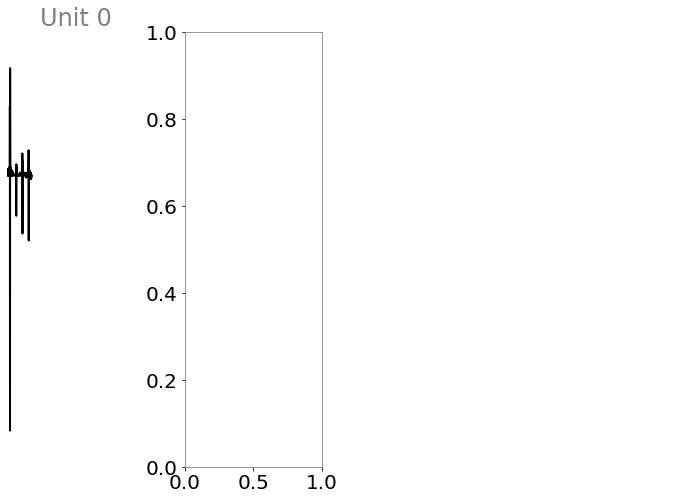

In [95]:
w_wf = sw.plot_unit_templates(sorting=sorting_IC, recording=r_cache, unit_ids=[0,1,2,3])  

# Is this the reason, we used 0-indexing at some point? Should I change this for axonarawio in neo? 
# Sam said to use what is conventional / in the original recording, which is 1-based.

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

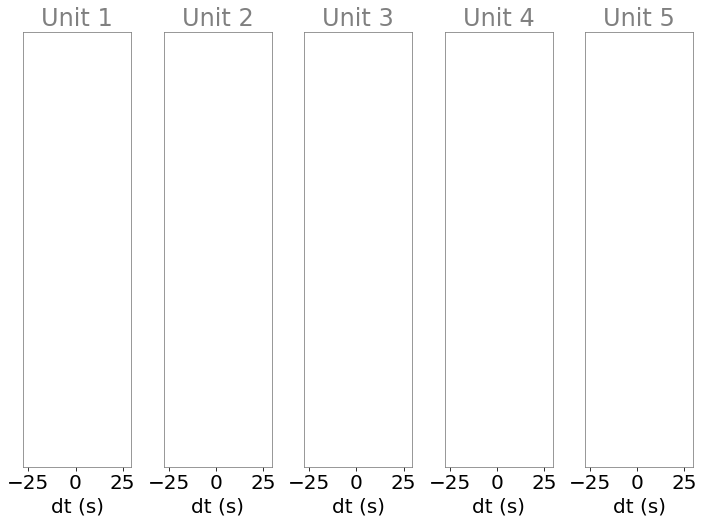

In [96]:
w_acc = sw.plot_autocorrelograms(sorting_IC, unit_ids=[1,2,3,4,5])

### Compute extracellular features

Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` module of `spiketoolkit` allows one to compute several of these features:

In [97]:
st.postprocessing.get_template_features_list()

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [98]:
features = st.postprocessing.compute_unit_template_features(
    r_cache, 
    sorting_KL, 
    as_dataframe=True, 
    upsampling_factor=10
)
display(features)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.000148,0.000067,-0.436231,4.733126e+08,-1.226948e+07
1,0.001112,0.000438,-0.883200,2.112091e+07,-1.734475e+07
2,0.000148,0.000110,-0.582135,4.959484e+08,-2.245002e+07
3,0.004377,0.005138,-1.676857,5.318234e+07,-1.411151e+08
4,0.001373,0.000425,-0.601487,2.769485e+07,-1.225613e+07
5,0.000281,0.001985,-2.346352,2.058865e+08,-7.994098e+06
6,0.000135,0.000102,-0.381120,2.566309e+08,-5.508842e+06
7,0.001058,0.002785,-0.758754,2.619423e+07,-3.698753e+07
8,0.001985,0.005900,-1.317699,3.723509e+08,-5.132275e+07
9,0.000131,0.000096,-0.572485,3.127731e+08,-1.118737e+07


For more information about these waveform features, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

### Validation

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module.

Let's see what metrics are available:

In [99]:
st.validation.get_quality_metrics_list()

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

We can either compute one metric at a time, or compute a subset of metrics using the `compute_quality_metrics` function. 


In [100]:
duration = r_cache.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_KL, duration_in_frames=duration)
print('ISI violations:', isi_violations)

snrs = st.validation.compute_snrs(sorting_KL, r_cache)
print('SNRs:', snrs)

ISI violations: [0.4439849  2.26174744 0.42487476 0.         2.19885934 4.14400414
 1.16146829 4.28143285 0.         0.17930569 0.         7.944718
 2.15092846 0.5394055 ]
SNRs: [3.5791209 2.345877  5.280814  4.378199  5.136734  7.5310607 4.94042
 5.7446384 2.2128081 5.4549556 4.8449516 5.854383  7.7474394 4.0894837]


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

In [101]:
quality_metrics = st.validation.compute_quality_metrics(
    sorting_KL, 
    r_cache, 
    metric_names=['firing_rate', 'isi_violation', 'snr'], 
    as_dataframe=True
)
display(quality_metrics)

,firing_rate,isi_violation,snr
0,507.0,0.443985,3.579121
1,129.5,2.261747,2.345877
2,79.5,0.424875,5.280814
3,3.5,0.000000,4.378199
4,31.5,2.198859,5.136734
5,18.0,4.144004,7.531061
6,17.0,1.161468,4.940420
7,14.0,4.281433,5.744638
8,4.0,0.000000,2.212808
9,143.5,0.179306,5.454956


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

<a id="spike_curation"></a>
# 7. Curation
[back to index](#index)

### 1) Manual curation using Phy

To perform manual curation we will export the data to [Phy](https://github.com/cortex-lab/phy). 

In [45]:
!pip install phy --pre --upgrade

  Using cached phy-2.0b1-py2.py3-none-any.whl (593 kB)
  Using cached phylib-2.2-py2.py3-none-any.whl (89 kB)
  Using cached mtscomp-1.0.1-py2.py3-none-any.whl (15 kB)
  Using cached colorcet-2.0.6-py2.py3-none-any.whl (1.6 MB)
  Using cached mkdocs-1.1.2-py3-none-any.whl (6.4 MB)
  Using cached PyOpenGL-3.1.5-py3-none-any.whl (2.4 MB)
     |████████████████████████████████| 76 kB 1.9 MB/s eta 0:00:011
  Using cached pyct-0.4.8-py2.py3-none-any.whl (15 kB)
  Using cached lunr-0.5.8-py2.py3-none-any.whl (2.3 MB)
Processing /home/steburg/.cache/pip/wheels/48/d7/34/372e0521bd5c9f6dcdff307e37ef6f9c00c1e1e2afc9707b5c/livereload-2.6.3-py2.py3-none-any.whl
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached QtPy-1.9.0-py2.py3-none-any.whl (54 kB)
Processing /home/steburg/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4/future-0.18.2-py3-none-any.whl
Processing /home/steburg/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44

In [104]:
st.postprocessing.export_to_phy(
    r_cache, 
    sorting_IC, 
    output_folder='phy_IC',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00, 10.95it/s]

Converting to Phy format
Number of chunks: 1 - Number of jobs: 1


Fitting PCA of 3 dimensions on 4087 waveforms
Projecting waveforms on PC


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

Saving files
Saved phy format to:  /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/phy_IC
Run:

phy template-gui  /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/phy_IC/params.py


If you have trouble using the GUI from phy refer to the instructions here: https://github.com/cortex-lab/phy.

In [8]:
!pip install PyQt5

  Using cached PyQt5-5.15.4-cp36.cp37.cp38.cp39-abi3-manylinux2014_x86_64.whl (8.3 MB)
  Using cached PyQt5_sip-12.8.1-cp38-cp38-manylinux1_x86_64.whl (293 kB)
  Using cached PyQt5_Qt5-5.15.2-py3-none-manylinux2014_x86_64.whl (59.9 MB)


In [9]:
!pip install PyQtWebEngine

  Using cached PyQtWebEngine-5.15.4-cp36.cp37.cp38.cp39-abi3-manylinux2014_x86_64.whl (229 kB)
  Using cached PyQtWebEngine_Qt5-5.15.2-py3-none-manylinux2014_x86_64.whl (67.5 MB)


In [7]:
!phy template-gui phy_KL/params.py

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-steburg'
15:17:00.205 [I] state:180            Copied /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/phy/apps/template/static/state.json to /home/steburg/.phy/TemplateGUI/state.json.
[829:865:0404/151703.508393:ERROR:udev_watcher.cc(61)] Failed to enable receiving udev events.
15:17:08.245 [W] gui:671              Could not create view TemplateFeatureView.
js: Uncaught SyntaxError: Unexpected token '<'
15:17:17.210 [E] qt:449               [JS:L02] Uncaught SyntaxError: Unexpected token '<'
js: Uncaught SyntaxError: Unexpected token '<'
15:20:47.716 [E] qt:449               [JS:L02] Uncaught SyntaxError: Unexpected token '<'
15:21:22.956 [E] qt:178               Timeout in _block().
15:21:24.729 [E] __init__:62          An error has occurred (RuntimeError): Timeout in _block().
Traceback (most recent call last):
  File "/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.

In [8]:
%%capture --no-display
!phy template-gui phy_KL/params.py

After curating the results we can reload it using the PhySortingExtractor:

In [9]:
sorting_KL_phy_curated = se.PhySortingExtractor('phy_KL/', exclude_cluster_groups=['noise'])

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extractors/phyextractors/phyextractors.py:145: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(row[1], (int, np.int, float, np.float, str)) and len(row) == 2:
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extractors/phyextractors/phyextractors.py:145: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is s

In [10]:
print(len(sorting_KL_phy_curated.get_unit_ids()))
print(f"Unit ids after manual curation: {sorting_KL_phy_curated.get_unit_ids()}")

9
Unit ids after manual curation: [0, 1, 2, 3, 4, 5, 6, 7, 8]


### b) Automatic curation based on quality metrics

In [28]:
snr_thresh = 5
isi_viol_thresh = 0.5

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
sorting_auto = st.curation.threshold_isi_violations(sorting_KL, isi_viol_thresh, 'greater', duration)

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

In [30]:
len(sorting_auto.get_unit_ids())

7

In [31]:
sorting_auto = st.curation.threshold_snrs(sorting_auto, r_cache, snr_thresh, 'less')

In [32]:
len(sorting_auto.get_unit_ids())

1

### c) Consensus-based curation

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the comparison module. We first compare and match the output spike trains of the different sorters, and we can then extract a new SortingExtractor with only the units in agreement.

In [33]:
mcmp = sc.compare_multiple_sorters([sorting_KL, sorting_IC], ['KL', 'IC'], spiketrain_mode='union',
                                   verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing:  KL  and  IC
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomaprison step 4: extract agreement from graph


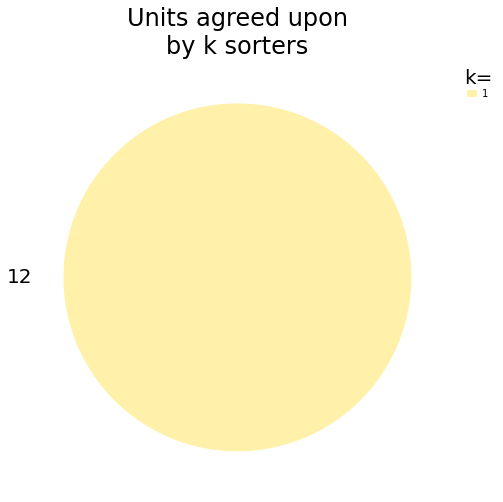

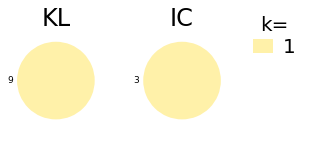

In [34]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [35]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [36]:
agreement_sorting.get_unit_ids()

[]

In [37]:
cmp_manual_agr = sc.compare_sorter_to_ground_truth(sorting_KL_phy_curated, agreement_sorting)

NameError: name 'sorting_KL_phy_curated' is not defined

In [40]:
w_agr = sw.plot_agreement_matrix(cmp_manual_agr)

NameError: name 'cmp_manual_agr' is not defined

In [41]:
st.postprocessing.export_to_phy(r_cache, 
                                agreement_sorting, output_folder='phy_AGR',
                                grouping_property='group', verbose=True, recompute_info=True)

Exception: No non-empty units in the sorting result, can't save to phy.

In [ ]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

<a id="export_nwb"></a>
# 7. Save to / load from NWB
[back to index](#index)

TODO delete

Follow https://github.com/catalystneuro/nwb-conversion-tools/blob/master/documentation/conversion_tools_structure.md#step-by-step-operations

and https://github.com/catalystneuro/movshon-lab-to-nwb/blob/main/tutorials/openephys_nwb_conversion_detailed.ipynb

In [9]:
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget
from pathlib import Path
import yaml
import pprint

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/hdmf/spec/namespace.py:206: PendingDeprecationWarning: 
safe_load will be removed, use

  yaml=YAML(typ='safe', pure=True)
  yaml.load(...)

instead
  d = yaml.safe_load(stream)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ruamel/yaml/main.py:1105: PendingDeprecationWarning: 
load will be removed, use

  yaml=YAML(typ='unsafe', pure=True)
  yaml.load(...)

instead
  return load(stream, SafeLoader, version)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/hdmf/spec/namespace.py:215: PendingDeprecationWarning: 
safe_load will be removed, use

  yaml=YAML(typ='safe', pure=True)
  yaml.load(...)

instead
  specs = yaml.safe_load(stream)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:282: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registr

In [ ]:
# TODO ...

In [105]:
metadata = {'Ecephys': {'Device': [{'name': 'Axona',
                                    'description': 'Axona DacqUSB acquisition system'}]}}

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
type(r_cache)

spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor

In [106]:
metadata

{'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB acquisition system'}]}}

In [110]:
se.NwbRecordingExtractor.write_recording(r_cache, 'axona_tutorial_re2.nwb')

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/hdmf/common/table.py:415: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:793: UserWarning: The recording extractor does not have unscaled traces. Returning scaled traces
  warnings.warn("The recording extractor does not have unscaled traces. Returning scaled traces")


In [111]:
se.NwbSortingExtractor.write_sorting(sorting_KL, 'axona_tutorial_se2.nwb')

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1240: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(prop_value, (int, np.integer, float, np.float, str, bool)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1264: UserWarning: Description for property repolarization_slope not found in property_descriptions. Setting description to 'no description'
  warnings.warn(
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1264: UserWarning: D

In [112]:
recording_nwb = se.NwbRecordingExtractor('axona_tutorial_re2.nwb')

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


In [113]:
sorting_nwb = se.NwbSortingExtractor('axona_tutorial_se2.nwb')

Exception: No acquisitions found in the .nwb file.

<a id="export_tint"></a>
# 8. Save to / load from TINT
[back to index](#index)

In [ ]:
# TODO ...

In [ ]:
# eof